In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

#!pip install segmentation-models-pytorch==0.1.0
#!pip install -U segmentation-models-pytorch
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-5yt9lylt
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-5yt9lylt
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.1 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/mysegment

[Errno 2] No such file or directory: '/content/drive/MyDrive/mysegment'
/content


In [ ]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla T4


In [ ]:
print(torch.__version__)

2.1.0+cu118


In [ ]:
cd /content/drive/MyDrive/Deep Learning Project/F_segment/mysegment

/content/drive/.shortcut-targets-by-id/1x0w9ZjPh6RWzVe2rVLtgZWLZwHJ9eXRP/Deep Learning Project/F_segment/mysegment


In [ ]:
x_train_dir = os.path.join( "/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/image/train")
y_train_dir = os.path.join("/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/lables/train")

x_valid_dir = os.path.join("/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/image/val")
y_valid_dir = os.path.join( "/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/lables/val")

x_test_dir = os.path.join( "/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/image/test")
y_test_dir = os.path.join("/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/lables/test")

In [ ]:
print('the number of image/label in the train: ',len(os.listdir(x_train_dir)))
print('the number of image/label in the validation: ',len(os.listdir(x_valid_dir)))
print('the number of image/label in the test: ',len(os.listdir(x_test_dir)))

the number of image/label in the train:  300
the number of image/label in the validation:  100
the number of image/label in the test:  100


In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
CLASSES = ['1', '2', '3','4']


In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    """CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']"""

    CLASSES = ['1','2', '3' ,'4']
    randomizeLocation = None

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
            randomizeLocation=True,
    ):
        self.randomizeLocation = randomizeLocation
        self.ids = os.listdir(images_dir)
        self.mids = os.listdir(masks_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.images_fps.sort()


        #self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.mids]
        self.masks_fps.sort()



        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower())+1 for cls in classes]
        print(self.class_values)
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        randomIndex = 0
        if self.randomizeLocation:
          randomIndex = random.randint(0, len(image1) - 256)
        image=image1[randomIndex:randomIndex+256, randomIndex:randomIndex+256,:]
        image.shape
        mask1 = cv2.imread(self.masks_fps[i], 0)
        mask1[mask1 == 255] = 3
        mask1[mask1 == 128] = 2
        mask1[mask1 == 0] = 1
        mask=mask1[randomIndex:randomIndex+256, randomIndex:randomIndex+256]
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        #print(mask)

        # add background if mask is not binary
        #if mask.shape[-1] != 1:
        #    background = 1 - mask.sum(axis=-1, keepdims=True)
        #    mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

[1, 2, 3, 4]
(256, 256, 4)


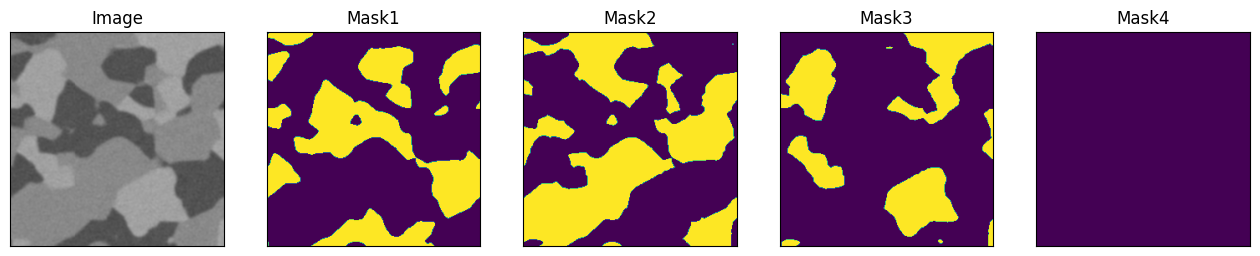

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]]


In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

image, mask = dataset[1] # get some sample
#print(mask)
print(mask.shape)
visualize(
    image=image,
    mask1=mask[..., 0].squeeze(),
    mask2=mask[..., 1].squeeze(),
    mask3=mask[..., 2].squeeze(),
    mask4=mask[..., 3].squeeze(),
)
print(mask[..., 0].squeeze())

In [ ]:
image, mask = dataset[1]
print(image.shape, mask.shape)

(256, 256, 3) (256, 256, 4)


In [ ]:
mask.shape

(256, 256, 4)

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.PadIfNeeded(min_height=256, min_width=256, always_apply=False, border_mode=0),
        albu.RandomCrop(height=256, width=256, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #albu.PadIfNeeded(384, 480)
        albu.PadIfNeeded(256, 256)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

[1, 2, 3, 4]


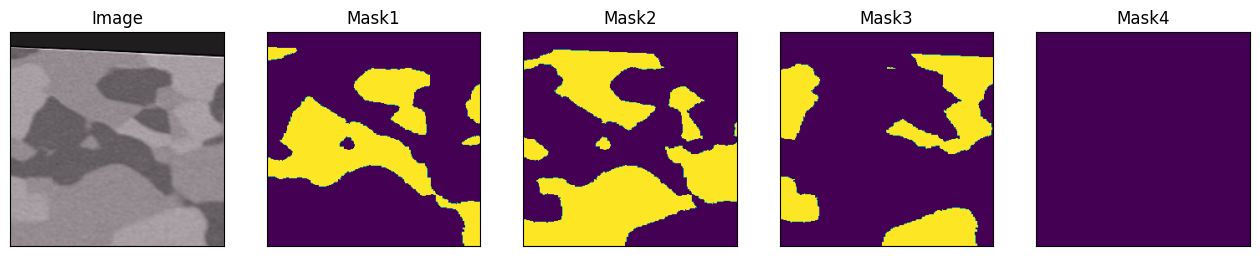

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES, augmentation=get_training_augmentation())

image, mask = dataset[1] # get some sample
visualize(
    image=image,
    mask1=mask[..., 0].squeeze(),
    mask2=mask[..., 1].squeeze(),
    mask3=mask[..., 2].squeeze(),
    mask4=mask[..., 3].squeeze(),
)

Create model and train

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
#ENCODER = 'resnext50_32x4d'
ENCODER = 'densenet161'
ENCODER_WEIGHTS = None
#ENCODER_WEIGHTS = 'ssl'
CLASSES = CLASSES
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

saveModelLocation = '/content/drive/MyDrive/Deep Learning Project/savedModels/'+ENCODER +"_NoPretrain"+'.pth'

print(smp.__version__)

#n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
n_classes = len(CLASSES)

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=n_classes,
    activation= 'softmax2d',
)

if torch.cuda.is_available():
    print('Cuda available')
    model.cuda()

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER)

0.3.3
Cuda available


In [ ]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

[1, 2, 3, 4]
[1, 2, 3, 4]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import segmentation_models_pytorch.utils.metrics
loss = smp.utils.losses.DiceLoss()
#loss = smp.utils.losses.CrossEntropyLoss()
metrics = [
    #smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy()
    #smp.utils.metrics.Fscore()
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)


valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model

max_score = 0
num_epochs = 10
#train accurascy, train loss, val_accuracy, val_loss をグラフ化できるように設定．
x_epoch_data = []
train_dice_loss = []
train_acc_score = []
valid_dice_loss = []
valid_acc_score = []
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

for i in range(0, num_epochs):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_acc_score.append(train_logs['accuracy'])
    #train_acc_score.append(train_logs['iou_score'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_acc_score.append(valid_logs['accuracy'])
    #valid_acc_score.append(valid_logs['iou_score'])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['accuracy']:
        max_score = valid_logs['accuracy']
        #max_score = valid_logs['iou_score']
        torch.save(model, saveModelLocation)

        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i == 50:
        optimizer.param_groups[0]['lr'] = 5e-6
        print('Decrease decoder learning rate to 5e-6!')

    if i == 75:
        optimizer.param_groups[0]['lr'] = 1e-6
        print('Decrease decoder learning rate to 1e-6!')

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

time = start.elapsed_time(end)
print("Time elapsed: " + str(start.elapsed_time(end) / 60000) + " minutes")  # milliseconds


Epoch: 0
valid: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s, dice_loss - 0.4466, accuracy - 0.8527]
Model saved!

Epoch: 1
valid: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s, dice_loss - 0.1854, accuracy - 0.97]
Model saved!

Epoch: 2
valid: 100%|██████████| 100/100 [00:05<00:00, 18.61it/s, dice_loss - 0.1382, accuracy - 0.9747]
Model saved!

Epoch: 3
valid: 100%|██████████| 100/100 [00:05<00:00, 16.91it/s, dice_loss - 0.1178, accuracy - 0.9772]
Model saved!

Epoch: 4
valid: 100%|██████████| 100/100 [00:06<00:00, 15.88it/s, dice_loss - 0.09809, accuracy - 0.9755]

Epoch: 5
valid: 100%|██████████| 100/100 [00:05<00:00, 18.53it/s, dice_loss - 0.1013, accuracy - 0.971]

Epoch: 6
valid: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s, dice_loss - 0.06807, accuracy - 0.9815]
Model saved!

Epoch: 7
valid: 100%|██████████| 100/100 [00:05<00:00, 18.02it/s, dice_loss - 0.05925, accuracy - 0.984]
Model saved!

Epoch: 8
valid: 100%|██████████| 100/100 [00:07<00:00, 14.25it/s, dice_los

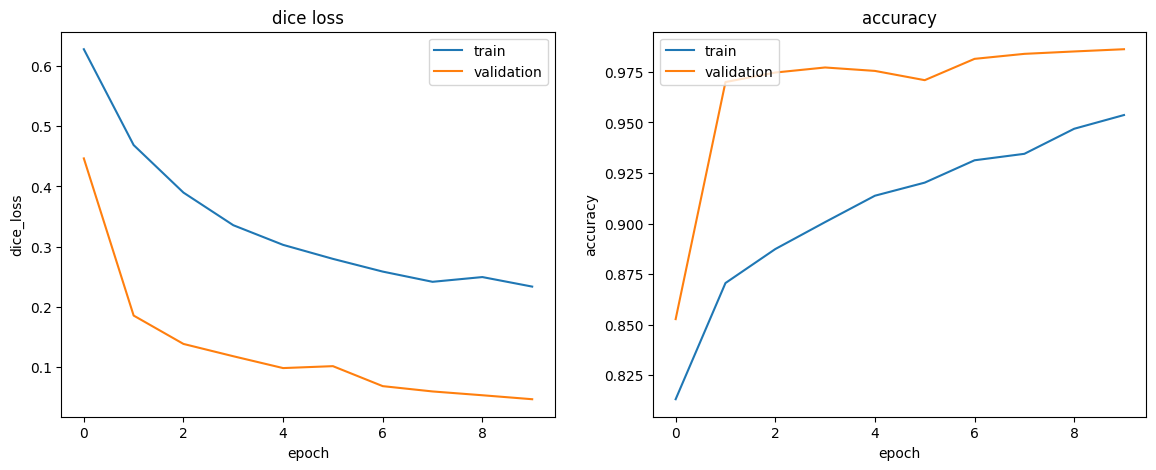

In [ ]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train')
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
line1, = ax2.plot(x_epoch_data,train_acc_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_acc_score,label='validation')
ax2.set_title("accuracy")
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(loc='upper left')

saveResultLocation = '/content/drive/MyDrive/Deep Learning Project/savedResults/'+ENCODER+"_NoPretrain"+'.png'
plt.savefig(saveResultLocation)

plt.show()

Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load(saveModelLocation)

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    randomizeLocation=False,
)

test_dataloader = DataLoader(test_dataset)

[1, 2, 3, 4]


In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 100/100 [01:42<00:00,  1.02s/it, dice_loss - 0.04632, accuracy - 0.9863]


Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir,
    classes=CLASSES,
    randomizeLocation=False,
)

[1, 2, 3, 4]


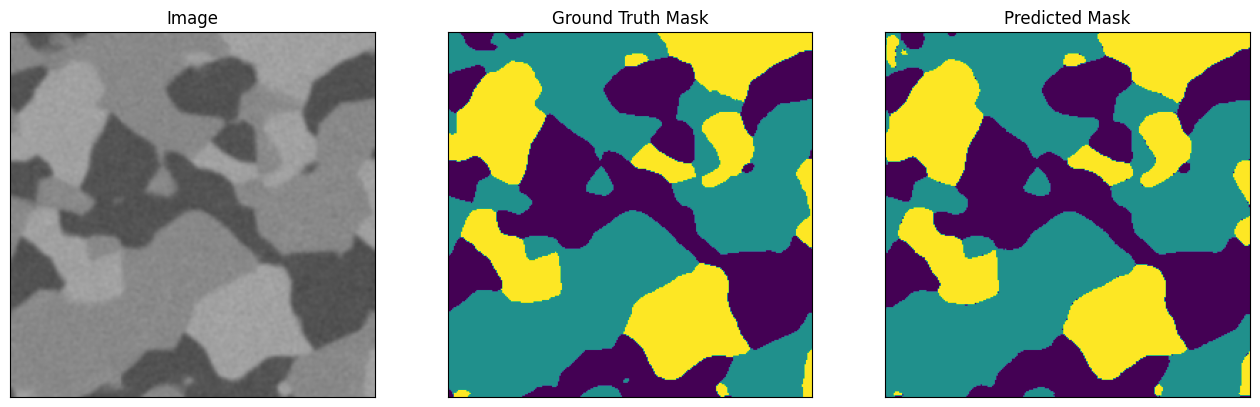

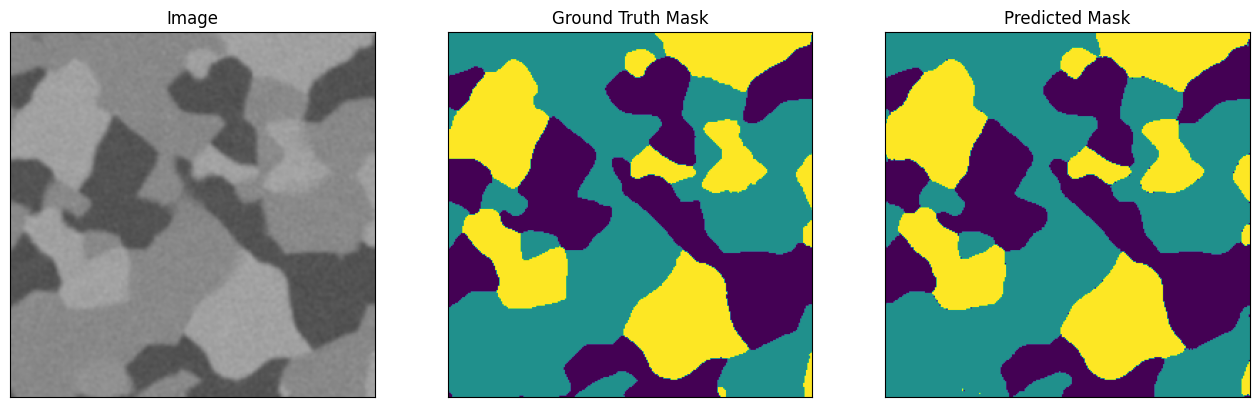

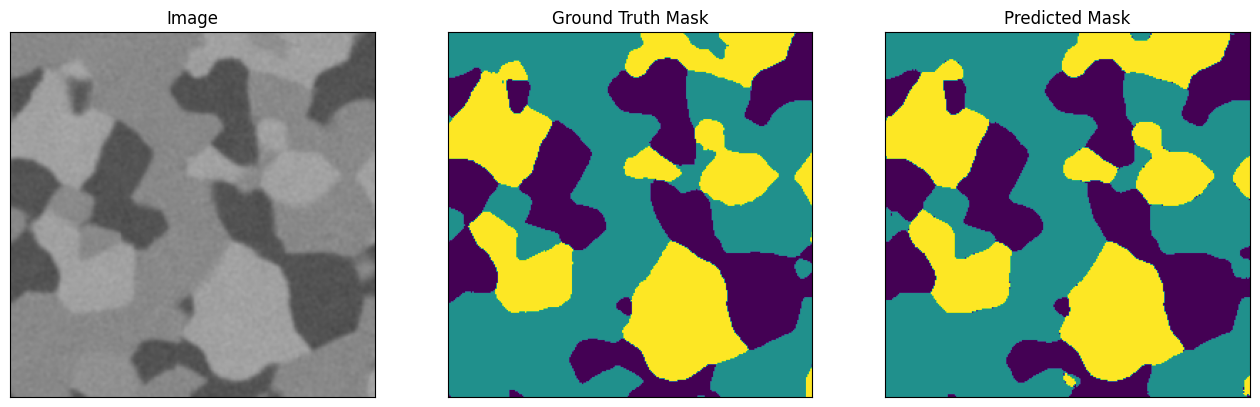

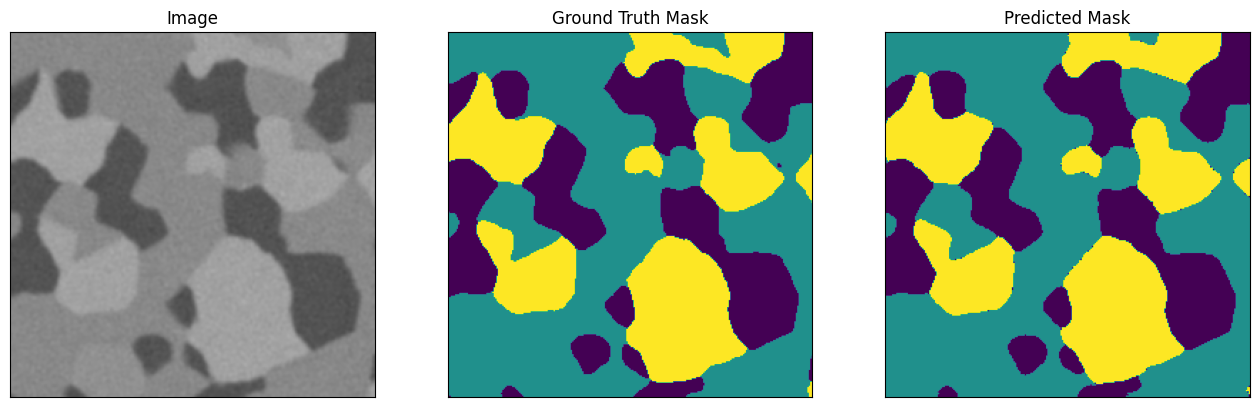

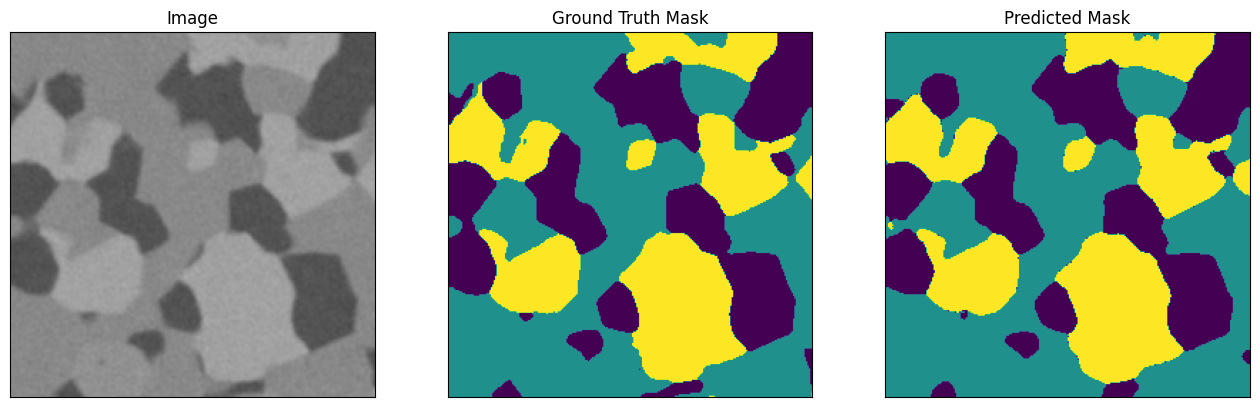

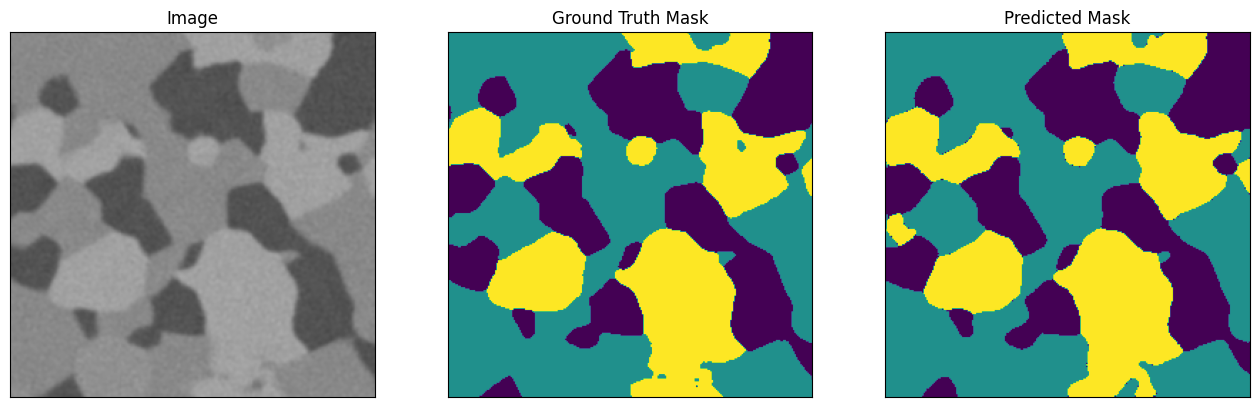

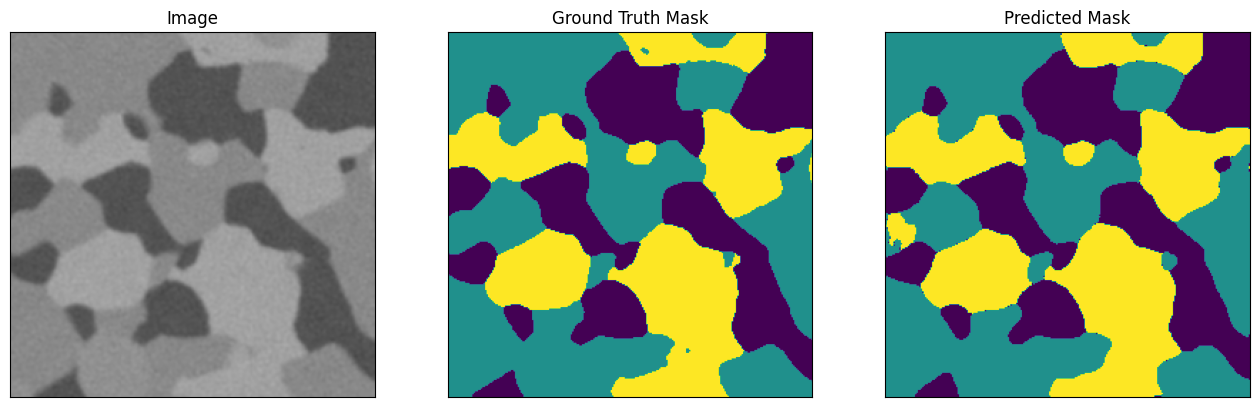

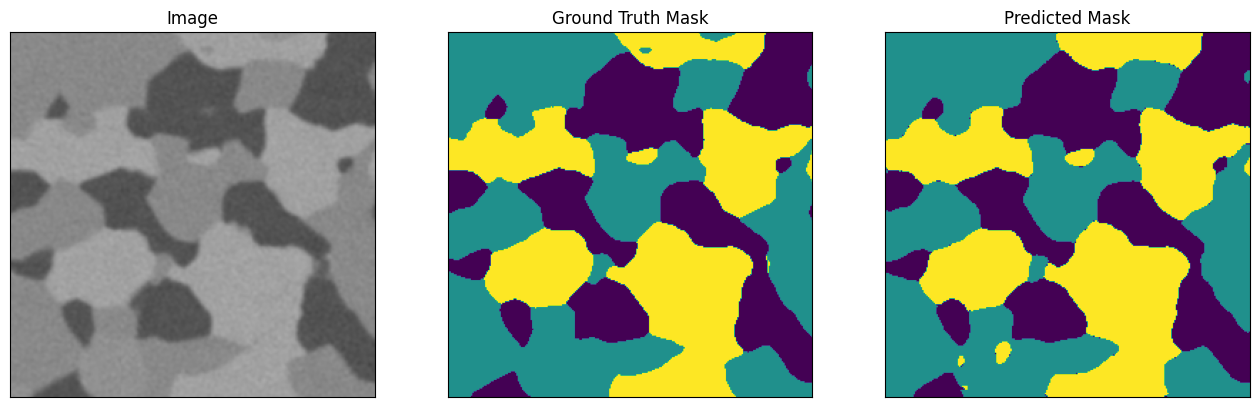

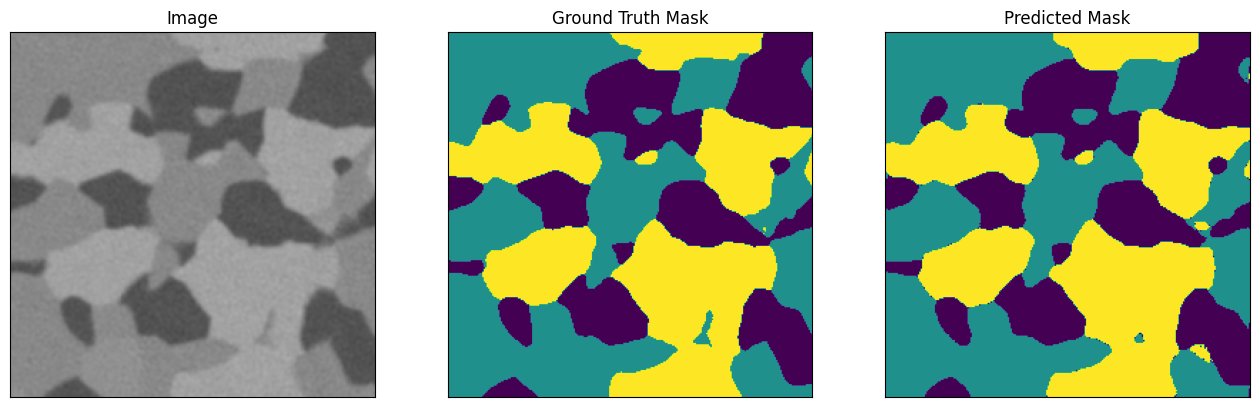

In [ ]:
for i in range(9):

    #n = np.random.choice(len(test_dataset))
    n = i

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    pr_mask = np.transpose(pr_mask, (1, 2, 0))



    gt_mask_gray = np.zeros((gt_mask.shape[0],gt_mask.shape[1]))

    for ii in range(gt_mask.shape[2]):
        gt_mask_gray = gt_mask_gray + 1/gt_mask.shape[2]*ii*gt_mask[:,:,ii]

    pr_mask_gray = np.zeros((pr_mask.shape[0],pr_mask.shape[1]))
    for ii in range(pr_mask.shape[2]):
        pr_mask_gray = pr_mask_gray + 1/pr_mask.shape[2]*ii*pr_mask[:,:,ii]

    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask_gray,
        predicted_mask=pr_mask_gray
        #predicted_mask=pr_mask[1].squeeze()
    )

    #CLASSES = ['1', '2', '3', '4']


In [ ]:
ls

best_model_quita.pth  data/  images/


#Trash Code modify

In [ ]:
# split my list
import os
import random
from glob import glob
from pprint import pprint
import uuid
import tempfile
import numpy as np
import pandas as pd
import json
import os
import sys
mids = os.listdir('/content/drive/MyDrive/mysegment/data/labels')
masks_fps = [os.path.join('/content/drive/MyDrive/mysegment/data/labels',mask_id) for mask_id in  mids]
masks_fps.sort()
print(masks_fps)
train_split_path = '/content/drive/MyDrive/mysegment/data/images.txt'



# class_idx_path = '/content/drive/My Drive/VCOP/data/ucf101/split/classInd.txt'
# class_idx2label = pd.read_csv(class_idx_path, header=None, sep=' ').set_index(0)[1]
# class_label2idx = pd.read_csv(class_idx_path, header=None, sep=' ').set_index(1)[0]


for  idx  in  range(len(train_split)):
    videoname =  train_split[idx]
    class_idx = cls[idx]
    print(videoname)
    print(class_idx)

    print('FightDST/'+ videoname,str(16),class_idx, file=open('/content/drive/MyDrive/gluon-cv/data/FightDST/train2new02.txt', 'a') )



In [ ]:
# split my list
import os
import random
from glob import glob
from pprint import pprint
import uuid
import tempfile
import numpy as np
import pandas as pd
import json
import os
import sys


import os
import random
from glob import glob
from pprint import pprint
import uuid
import tempfile
import numpy as np
import pandas as pd
import json
import os
import sys
mids = os.listdir('/content/drive/MyDrive/mysegment/data/image')
masks_fps = [os.path.join('/content/drive/MyDrive/mysegment/data/labels',mask_id) for mask_id in  mids]
masks_fps.sort()
print(masks_fps)


for  i  in  masks_fps:
      print(i)

      dst ="noFight" + str(count) + ".mp4"
      dst1=dst
      src =lst+ filename
      dst =lst+ dst
      #print(src,dst)
      #os.rename(src, dst)


    videoname =  train_split[idx]
    class_idx = cls[idx]
    print(videoname)
    print(class_idx)
    if  idx %7==0:
        print(videoname,class_idx, file=open('/content/drive/MyDrive/MyFight/data/FightDST/testlist03.txt', 'a') )
    else:
      if  idx %6==0:
        print(videoname,class_idx, file=open('/content/drive/MyDrive/MyFight/data/FightDST/trainlist02.txt', 'a') )
      else:
        print(videoname,class_idx, file=open('/content/drive/MyDrive/MyFight/data/FightDST/trainlist011.txt', 'a') )



['/content/drive/MyDrive/mysegment/data/labels/slice__001.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__002.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__003.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__004.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__005.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__006.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__007.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__008.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__009.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__010.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__011.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__012.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__013.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__014.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__015.tif', '/content/drive/MyDrive/mysegment/data/labels/slice__0

NameError: ignored

In [ ]:
cd /content/drive/MyDrive/mysegment/data

/content/drive/.shortcut-targets-by-id/13qpgwsb6q8U3fod1fvtOGZ1hHiz8lHZW/mysegment/data


In [ ]:
os.path.split()

In [ ]:


import os
import random
from glob import glob
from pprint import pprint
import uuid
import tempfile
import numpy as np
import pandas as pd
import json
import os
import sys
mids = os.listdir('/content/drive/MyDrive/mysegment/data/image')
masks_fps = [os.path.join(mask_id) for mask_id in  mids]
masks_fps.sort()
print(masks_fps)


for  i  in  masks_fps:
      [u,d]= os.path.split(i)
      #print(u,d[-7::] )
      src =i

      dst =d[-8::]
      #dst=d
      print(src,dst)
      os.rename(src, dst)

In [ ]:
cd /content/drive/MyDrive/mysegment/data/image

/content/drive/.shortcut-targets-by-id/13qpgwsb6q8U3fod1fvtOGZ1hHiz8lHZW/mysegment/data/image


In [ ]:
cd /content/drive/MyDrive/mysegment/data

/content/drive/.shortcut-targets-by-id/13qpgwsb6q8U3fod1fvtOGZ1hHiz8lHZW/mysegment/data


In [ ]:
mv 'data.txt' '/content/drive/MyDrive/mysegment/data/data.txt'

In [ ]:
# split my list
import os
import random
from glob import glob
from pprint import pprint
import uuid
import tempfile
import numpy as np
import pandas as pd
import json
import os
import sys


import os
import random
from glob import glob
from pprint import pprint
import uuid
import tempfile
import numpy as np
import pandas as pd
import json
import os
import sys
idx=0;
for line in open('data.txt'):
    idx=idx+1

    if  idx %5==0:
        print(videoname,class_idx, file=open('/test.txt', 'a') )
    else:
      if  idx %4==0:
        print(videoname,class_idx, file=open('val.txt', 'a') )
      else:
        print(videoname,class_idx, file=open('train.txt', 'a') )



for  i  in  masks_fps:
      print(i)


      dstmask ="train_lables\
      src =lst+ filename

      dstmtrain =dstmask+ dst
      #print(src,dst)
      #os.rename(src, dst)
    if  idx %7==0:
        print(videoname,class_idx, file=open('/content/drive/MyDrive/MyFight/data/FightDST/testlist03.txt', 'a') )
    else:
      if  idx %6==0:
        print(videoname,class_idx, file=open('/content/drive/MyDrive/MyFight/data/FightDST/trainlist02.txt', 'a') )
      else:
        print(videoname,class_idx, file=open('/content/drive/MyDrive/MyFight/data/FightDST/trainlist011.txt', 'a') )



IndentationError: ignored

In [ ]:
cd /content/drive/MyDrive/mysegment/data/

/content/drive/.shortcut-targets-by-id/13qpgwsb6q8U3fod1fvtOGZ1hHiz8lHZW/mysegment/data


In [ ]:
# split my list
import os
import random
from glob import glob
from pprint import pprint
import uuid
import tempfile
import numpy as np
import pandas as pd
import json
import os
import sys


import os
import random
from glob import glob
from pprint import pprint
import uuid
import tempfile
import numpy as np
import pandas as pd
import json
import os
import sys
idx=0
for line in open('data.txt'):
    idx=idx+1

    if  idx %5==0:
        print(line.strip(), file=open('test.txt', 'a') )
    else:
      if  idx %4==0:
        print(line.strip(), file=open('val.txt', 'a') )
      else:
        print(line.strip(), file=open('train.txt', 'a') )



In [ ]:
print(line.strip())

500.tiff


In [ ]:
cd /content/drive/MyDrive/mysegment/data/lables

/content/drive/.shortcut-targets-by-id/13qpgwsb6q8U3fod1fvtOGZ1hHiz8lHZW/mysegment/data/lables


In [ ]:

for line in open('/content/drive/MyDrive/mysegment/data/val.txt'):

      #print(u,d[-7::] )
      src =line.strip()

      dst = 'val/'+ src
      #dst=d
      print(src,dst)
      os.rename(src, dst)

#end code modify